In [1]:
# Exploring Data, Data Cleaning, changing variables based on what the values were assinged from a newspaper in the Suffolk area
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np


df = pd.read_csv('https://raw.githubusercontent.com/nickkas/python_ml_ect_/master/hmda.txt',delimiter='\t')

df.info()

df.isna().sum()
df.isnull().sum()

df.rename(columns={'s5':'occupancy','s7':'approve','s11':'county','s13':'race',
                   's15':'sex','s17':'income','s23a':'married','s27a':'self_employed',
                   's33':'purchase_price','s34':'other_financing','s35':'liquid_assets',
                   's40':'credit_history','s42':'chmp','s43':'chcp','s44':'chpr',
                   's45':'debt_to_expense','s46':'di_ratio','s50':'appraisal',
                   's53':'pmi_denied','netw':'net_worth','uria':'unemployment',
                   'school':'education','s56':'unverifiable',
                   's52':'pmi_sought'},inplace=True)





df['approved'] = [1 if X == 3 else 0 for X in df['approve']]
df['race'] = [0 if X == 3 else 1 for X in df['race']]
df['married'] = [1 if X == 'M' else 0 for X in df['married']]
df['sex'] = [1 if X == 1 else 0 for X in df['sex']]
df['credit_history'] = [1 if X == 1 else 0 for X in df['credit_history']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2380 entries, 0 to 2379
Data columns (total 62 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   seq      2380 non-null   int64  
 1   s3       2380 non-null   int64  
 2   s4       2380 non-null   int64  
 3   s5       2380 non-null   int64  
 4   s6       2380 non-null   int64  
 5   s7       2380 non-null   int64  
 6   s9       2380 non-null   int64  
 7   s11      2380 non-null   int64  
 8   s13      2380 non-null   int64  
 9   s14      2379 non-null   float64
 10  s15      2380 non-null   int64  
 11  s16      2379 non-null   float64
 12  s17      2380 non-null   float64
 13  s18      2265 non-null   float64
 14  s19a     193 non-null    object 
 15  s19b     246 non-null    float64
 16  s19c     86 non-null     float64
 17  s19d     13 non-null     float64
 18  s20      2380 non-null   float64
 19  s23a     2378 non-null   object 
 20  s24a     2380 non-null   int64  
 21  s25a     2380 

<Axes: >

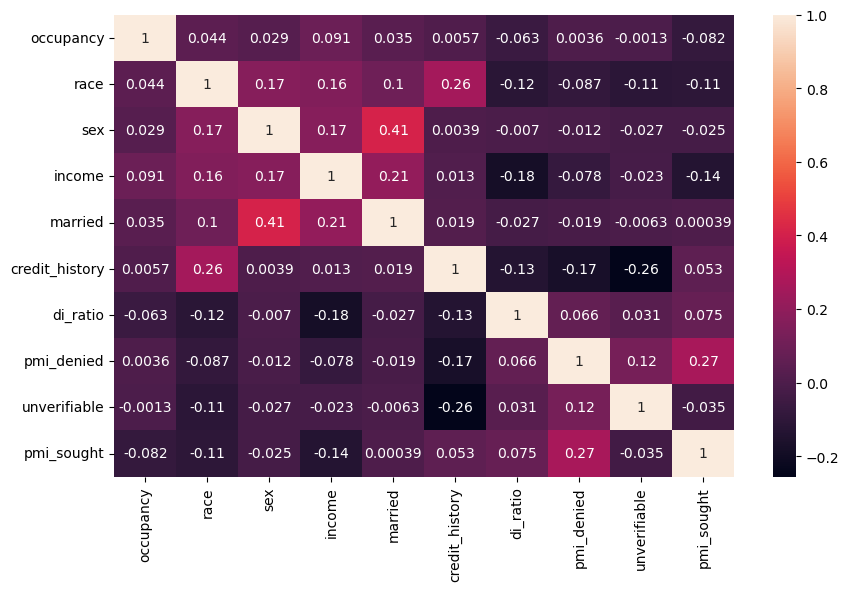

In [2]:
# Correlation Heatmap,selected features based on relevance,  
# and labelencoder is used and df1 is a copy of 'df' for visuals


df1 = df.copy()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for i in df1:
    df1[i] = le.fit_transform(df1[i])


# Features that will be selected for the models

features = ['occupancy','race','sex','income','married','credit_history','di_ratio',
            'pmi_denied','unverifiable','pmi_sought']



import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df1[features].corr(), annot=True)

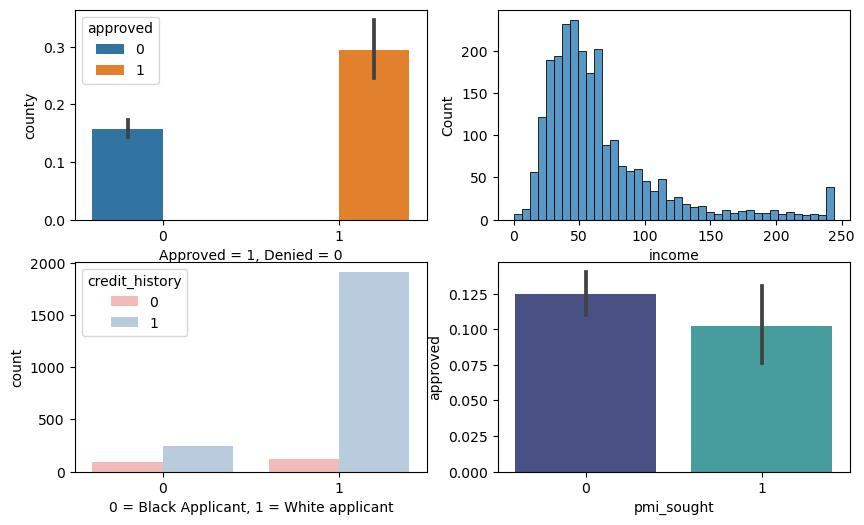

In [3]:
# A user-defined 'subplots' to explain visually, what the data looks like.
def subplots(df1):
    plt_,axs = plt.subplots(2,2,figsize=(10,6))
    sns.barplot(x='approved',y='county',ax=axs[0,0],data=df1,hue='approved')
    axs[0,0].set_label('approved VS county(Suffolk)')
    axs[0,0].set_xlabel('Approved = 1, Denied = 0')
    sns.histplot(x='income',ax=axs[0,1],data=df1)
    axs[0,1].set_label('Histogram of distribution of income')
    sns.countplot(x='race',ax=axs[1,0],data=df1,hue='credit_history',palette='Pastel1')
    axs[1,0].set_xlabel('0 = Black Applicant, 1 = White applicant')
    sns.barplot(x='pmi_sought',y='approved',ax=axs[1,1],data=df1,palette='mako')
    plt.show()


subplots(df1)

In [4]:
# The features selected above are then used as 'X' for the model evaluation and 'approved' is the target variable.
# The point of this is to measure the scores on the various models to see why applicants were approved or denied a loan
# statsmodels is imported to show the statistical significance of the features chosen through a ANOVA table
X = df[features]
y = df.approved

y.value_counts(normalize=True)


import statsmodels.api as sm

model = sm.OLS(y,X).fit()
print(model.summary())

# Train/Test split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

# Scaling the X values using Standard Scaler
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

                                 OLS Regression Results                                
Dep. Variable:               approved   R-squared (uncentered):                   0.519
Model:                            OLS   Adj. R-squared (uncentered):              0.517
Method:                 Least Squares   F-statistic:                              255.3
Date:                Mon, 25 Dec 2023   Prob (F-statistic):                        0.00
Time:                        23:18:58   Log-Likelihood:                          18.586
No. Observations:                2380   AIC:                                     -17.17
Df Residuals:                    2370   BIC:                                      40.58
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [5]:
# Models used: Logistic Regression, Random Forest, Decision Tree Classifier,
# Gradient Boost, Naive Bayes, LDA, K-Nearest Neighbors,
# SVC
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train_scaled,y_train)
lr_pred = lr.predict(X_test_scaled)
lr_pred_prob = lr.predict_proba(X_test_scaled)[::,1]

from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier

rfc = RandomForestClassifier().fit(X_train_scaled,y_train)
rfc_pred = rfc.predict(X_test_scaled)
rfc_pred_prob = rfc.predict_proba(X_test_scaled)[::,1]


gbc = GradientBoostingClassifier().fit(X_train_scaled,y_train)
gbc_pred = gbc.predict(X_test_scaled)
gbc_pred_prob = gbc.predict_proba(X_test_scaled)[::,1]


from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X_train_scaled,y_train)
tree_pred = tree.predict(X_test_scaled)
tree_pred_prob = tree.predict_proba(X_test_scaled)[::,1]



from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train_scaled,y_train)
nb_pred = nb.predict(X_test_scaled)
nb_pred_prob = nb.predict_proba(X_test)[::,1]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis().fit(X_train_scaled,y_train)
lda_pred = lda.predict(X_test_scaled)
lda_pred_prob = lda.predict_proba(X_test_scaled)[::,1]


from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7).fit(X_train_scaled,y_train)
knn_pred = knn.predict(X_test_scaled)
knn_pred_prob = knn.predict_proba(X_test_scaled)[::,1]


from sklearn.svm import SVC

svc = SVC(probability=True).fit(X_train_scaled,y_train)
svc_pred = svc.predict(X_test_scaled)
svc_pred_prob = svc.predict_proba(X_test_scaled)[::,1]

In [6]:
# Scoring the models by roc_auc score, accuracy, and f1 score

from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,f1_score


def evaluate(y_test,y_pred,y_pred_prob,model_name):
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)
    print(f'{model_name} --Accuracy-- {acc*100:.2f}%; --ROC-- {roc*100:.2f}%; --F1-- {f1*100:.2f}%')
    
    
evaluate(y_test, lr_pred, lr_pred_prob, 'Logistic Regression')
evaluate(y_test,rfc_pred,rfc_pred_prob, 'Random Forest')
evaluate(y_test, gbc_pred, gbc_pred_prob, 'Gradient Boost')
evaluate(y_test, tree_pred, tree_pred_prob, 'Decision Tree Classifier')
evaluate(y_test,nb_pred,nb_pred_prob,'Naive Bayes')
evaluate(y_test, lda_pred, lda_pred_prob, 'LDA')
evaluate(y_test, knn_pred, knn_pred_prob, 'K-Nearest Neighbors')
evaluate(y_test, svc_pred, svc_pred_prob, 'SVM')

Logistic Regression --Accuracy-- 94.75%; --ROC-- 91.84%; --F1-- 75.25%
Random Forest --Accuracy-- 94.33%; --ROC-- 90.40%; --F1-- 73.79%
Gradient Boost --Accuracy-- 93.07%; --ROC-- 91.25%; --F1-- 67.96%
Decision Tree Classifier --Accuracy-- 92.02%; --ROC-- 82.51%; --F1-- 67.80%
Naive Bayes --Accuracy-- 93.49%; --ROC-- 50.00%; --F1-- 73.95%
LDA --Accuracy-- 95.17%; --ROC-- 91.73%; --F1-- 78.10%
K-Nearest Neighbors --Accuracy-- 93.70%; --ROC-- 90.66%; --F1-- 70.59%
SVM --Accuracy-- 94.33%; --ROC-- 90.82%; --F1-- 74.29%


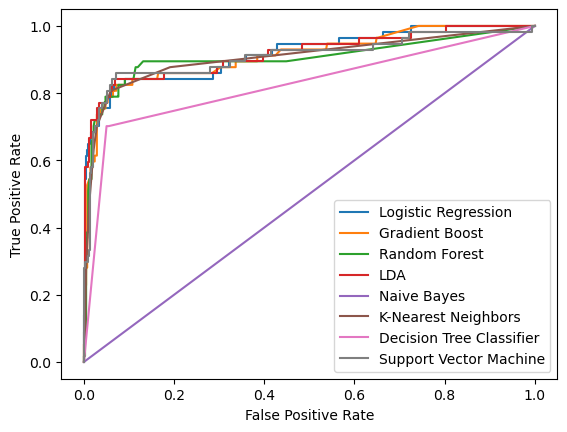

In [7]:
# A ROC Cuvre for all of the models together
def ROC(y_test,y_pred_prob,model_name):
    fpr,tpr, _ = roc_curve(y_test,y_pred_prob)
    plt.plot(fpr,tpr,label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    


ROC(y_test, lr_pred_prob,'Logistic Regression')
ROC(y_test,gbc_pred_prob,'Gradient Boost')
ROC(y_test, rfc_pred_prob, 'Random Forest')
ROC(y_test,lda_pred_prob,'LDA')
ROC(y_test, nb_pred_prob, 'Naive Bayes')
ROC(y_test, knn_pred_prob, 'K-Nearest Neighbors')
ROC(y_test,tree_pred_prob,'Decision Tree Classifier')
ROC(y_test, svc_pred_prob, 'Support Vector Machine')
plt.legend()
plt.show()

In [8]:
# The following is a Grid Search for Hyperparameter Tuning. Parts of this may take a while to run.
# Grid Search for Logistic Regression Model

from sklearn.model_selection import GridSearchCV


lr_param_grid = {'C': [0.001,0.01,0.1,1,10,100]}
lr_grid = GridSearchCV(LogisticRegression(),param_grid=lr_param_grid,scoring='roc_auc',cv=5).fit(X_train_scaled,y_train)
lr_grid_pred = lr_grid.best_estimator_.predict(X_test_scaled)
lr_grid_pred_prob = lr_grid.best_estimator_.predict_proba(X_test_scaled)[::,1]
print(f'Best ROC AUC score: {lr_grid.best_score_*100:.2f}%')
print('Predicted', np.round(lr_grid_pred_prob*100,2).max())

Best ROC AUC score: 91.45%
Predicted 100.0


In [9]:
# Grid Search for Random Forest Classifier

rfc_param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None,10],
    'min_samples_split':[2,5],
    'min_samples_leaf': [1,2]
}

rfc_grid = GridSearchCV(RandomForestClassifier(),param_grid=rfc_param_grid,scoring='roc_auc',cv=5).fit(X_train_scaled,y_train)
rfc_grid_pred = rfc_grid.best_estimator_.predict(X_test_scaled)
rfc_grid_pred_prob = rfc_grid.best_estimator_.predict_proba(X_test_scaled)[::,1]
print(f'Best ROC AUC score for Random Forest: {rfc_grid.best_score_*100:.2f}%')
print('Predicted',np.round(rfc_grid_pred_prob*100,2).max())

Best ROC AUC score for Random Forest: 90.20%
Predicted 95.23


In [14]:
#Gradient Boost Grid Search

gbc_param_grid = {
    'n_estimators':[50,100],
    'learning_rate':[0.01,0.1],
    'max_depth':[3,5],
    'min_samples_split':[2,5]
}
gbc_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=gbc_param_grid, scoring='roc_auc', cv=5).fit(X_train_scaled,y_train)
gbc_grid_pred = gbc_grid.best_estimator_.predict(X_test_scaled)
gbc_grid_pred_prob = gbc_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print(f'Best ROC AUC score for Gradient Boosting: {gbc_grid.best_score_*100:.2f}%')
print('Predicted', np.round(gbc_grid_pred_prob*100,2).max())

Best ROC AUC score for Gradient Boosting: 91.20%
Predicted 99.28


In [10]:
# Support Vector Machine Grid Search

svc_param_grid ={'C':[0.001,0.01,0.1,1,10,100],'gamma':['scale', 'auto']}
svc_grid = GridSearchCV(SVC(probability=True),param_grid=svc_param_grid,scoring='roc_auc',cv=10).fit(X_train_scaled,y_train)
svc_grid_pred = svc_grid.best_estimator_.predict(X_test_scaled)
svc_grid_pred_prob = svc_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print(f'Best ROC AUC score for Support Vector Machine: {svc_grid.best_score_*100:.2f}%')
print('Predicted', np.round(svc_grid_pred_prob*100,2).max())


Best ROC AUC score for Support Vector Machine: 88.65%
Predicted 97.71


In [11]:
# K-Nearest Neighbors


knn_param_grid = {'n_neighbors':[3,5,7],'p':[1,2]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_param_grid,scoring='roc_auc',cv=5).fit(X_train_scaled,y_train)
knn_grid_pred = knn_grid.best_estimator_.predict(X_test_scaled)
knn_grid_pred_prob = knn_grid.best_estimator_.predict_proba(X_test_scaled)[::,1]
print(f'Best ROC AUC score for K-Nearest Neighbors: {knn_grid.best_score_*100:.2f}%')
print('Predicted', np.round(knn_grid_pred_prob*100,2).max())

Best ROC AUC score for K-Nearest Neighbors: 85.26%
Predicted 100.0


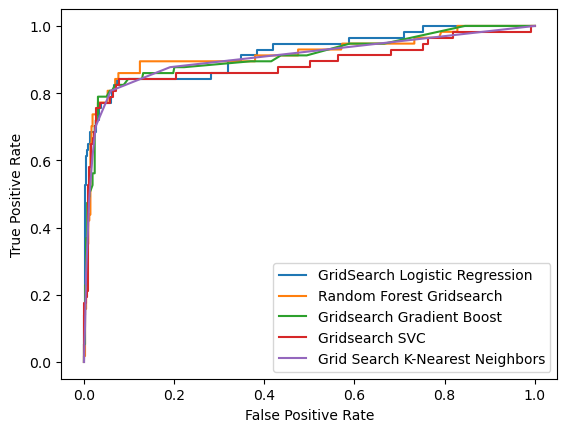

In [15]:
# ROC Curves of the tuned Hyper Parameters. Did not use Naive Bayes, Decision Trees or LDA.


ROC(y_test,lr_grid_pred_prob,'GridSearch Logistic Regression')
ROC(y_test, rfc_grid_pred_prob, 'Random Forest Gridsearch')
ROC(y_test,gbc_grid_pred_prob,'Gridsearch Gradient Boost')
ROC(y_test,svc_grid_pred_prob,'Gridsearch SVC')
ROC(y_test,knn_grid_pred_prob,'Grid Search K-Nearest Neighbors')
plt.legend()
plt.show()